In [1]:
import imblearn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_selection import VarianceThreshold, RFE, RFECV
from sklearn.metrics import auc, accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
import xgboost

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)

Using TensorFlow backend.


In [2]:
field_names = pd.read_csv("./Field Names.csv", names=["header", "type", "remarks"])

In [3]:
field_names.head()

,header,type,remarks
0,duration,continuous,NaN
1,protocol_type,symbolic,NaN
2,service,symbolic,NaN
3,flag,symbolic,NaN
4,src_bytes,continuous,NaN


In [4]:
added_field_names = pd.DataFrame({"header":["attack", "cnt_correct"],
                                 "type":["symbolic", "count"]})

In [5]:
field_names = field_names.append(added_field_names).reset_index().drop("index", axis=1)

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\pandas\core\frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [6]:
data = pd.read_csv("KDDTrain+.txt", names=field_names["header"])

In [7]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [8]:
attack_types = pd.read_csv("./Attack Types.csv", names=["attack", "category", "remarks"])

In [9]:
attack_types.head()

,attack,category,remarks
0,back,dos,NaN
1,buffer_overflow,u2r,NaN
2,ftp_write,r2l,NaN
3,guess_passwd,r2l,NaN
4,imap,r2l,NaN


In [10]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
attack_types.tail()

,attack,category,remarks
36,worm,r2l,added (not in training set)
37,xlock,r2l,added (not in training set)
38,xsnoop,r2l,added (not in training set)
39,sqlattack,u2r,added (not in training set)
40,udpstorm,dos,added (not in training set)


In [12]:
data = pd.merge(data, attack_types, on="attack", how="left")

In [13]:
for category in data["category"].unique():
    print("Category is %s" %(category))
    print(data[data["category"] == category].describe()["cnt_correct"])
    print("\n")

Category is normal
count    67343.000000
mean     20.315920   
std      1.482986    
min      1.000000    
25%      20.000000   
50%      21.000000   
75%      21.000000   
max      21.000000   
Name: cnt_correct, dtype: float64


Category is dos
count    45927.000000
mean     19.311560   
std      1.779125    
min      3.000000    
25%      18.000000   
50%      20.000000   
75%      21.000000   
max      21.000000   
Name: cnt_correct, dtype: float64


Category is r2l
count    995.000000
mean     9.878392  
std      4.030853  
min      0.000000  
25%      8.000000  
50%      11.000000 
75%      13.000000 
max      19.000000 
Name: cnt_correct, dtype: float64


Category is probe
count    11656.000000
mean     16.461050   
std      2.824638    
min      0.000000    
25%      15.000000   
50%      17.000000   
75%      18.000000   
max      21.000000   
Name: cnt_correct, dtype: float64


Category is u2r
count    52.000000
mean     4.403846 
std      3.951965 
min      0.000000 
25%    

In [14]:
# There are no nulls
data[data["attack"].isna()]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks


In [15]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,NaN
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,NaN
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos,NaN
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,NaN
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,NaN


In [16]:
data.shape

(125973, 45)

In [17]:
uniq_category_cnt_df = data[["attack", "category"]].groupby("category").count().reset_index().rename(columns={"attack": "count"}).sort_values("count", ascending=False)

In [18]:
uniq_category_cnt_df

,category,count
1,normal,67343
0,dos,45927
2,probe,11656
3,r2l,995
4,u2r,52


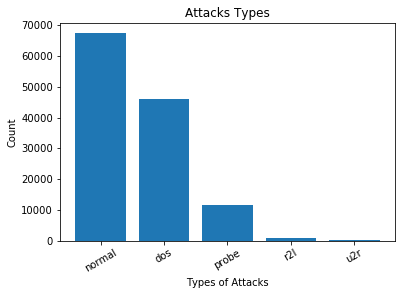

In [19]:
label = uniq_category_cnt_df["category"]

index = np.arange(len(label))
plt.bar(label, uniq_category_cnt_df["count"])
plt.xlabel('Types of Attacks', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=30)
plt.title('Attacks Types')
plt.show()


In [20]:
uniq_attack_cnt_df = data[["attack", "category"]].groupby("attack").count().reset_index().rename(columns={"category": "count"}).sort_values("count", ascending=False)

In [21]:
uniq_attack_cnt_df

,attack,count
11,normal,67343
9,neptune,41214
17,satan,3633
5,ipsweep,3599
15,portsweep,2931
18,smurf,2646
10,nmap,1493
0,back,956
20,teardrop,892
21,warezclient,890


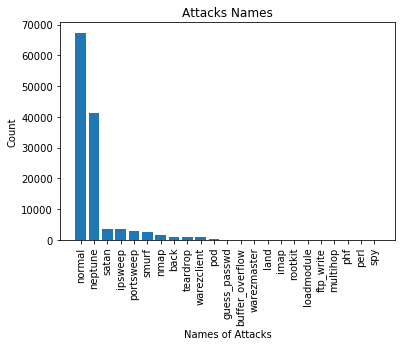

In [22]:
label = uniq_attack_cnt_df["attack"]

index = np.arange(len(label))
plt.bar(label, uniq_attack_cnt_df["count"])
plt.xlabel('Names of Attacks', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=90)
plt.title('Attacks Names')
plt.show()


In [23]:
features = list(field_names["header"])
features.remove("attack")
features.remove("cnt_correct")

In [24]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,cnt_correct
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.0,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,0.001342,0.001103,0.302192,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.107555,27.737888,0.284485,0.282485,0.119958,0.121183,0.660928,0.063053,0.097322,182.148945,115.653005,0.521242,0.082951,0.148379,0.032542,0.284452,0.278485,0.118832,0.120240,19.504060
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,0.036603,0.045154,24.399618,0.483935,0.022181,0.099370,0.0,0.002817,0.096612,114.508607,72.635840,0.446456,0.447022,0.320436,0.323647,0.439623,0.180314,0.259830,99.206213,110.702741,0.448949,0.188922,0.308997,0.112564,0.444784,0.445669,0.306557,0.319459,2.291503
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [25]:
types = list(field_names["type"])

In [26]:
possible_categorical_col = ["logged_in", "is_host_login", "is_guest_login", "root_shell", "su_attempted"]
possible_categorical_col = ["wrong_fragment", "urgent", "hot", "land"]

for col in possible_categorical_col:
    print("Showing feature %s" %(col))
    print("There are %s unique values" %(data[col].nunique()))
    print(data[col].unique())
    print("\n")

Showing feature wrong_fragment
There are 3 unique values
[0 3 1]


Showing feature urgent
There are 4 unique values
[0 1 3 2]


Showing feature hot
There are 28 unique values
[ 0  5  6  4  2  1 28 30 22 24 14  3 15 25 19 18 77 17 11  7 20 12  9 10
  8 21 33 44]


Showing feature land
There are 2 unique values
[0 1]




Showing feature duration


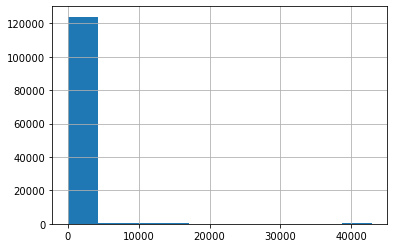

Showing feature protocol_type


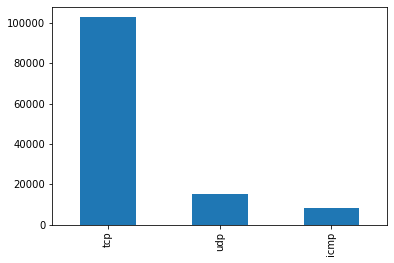

Showing feature service


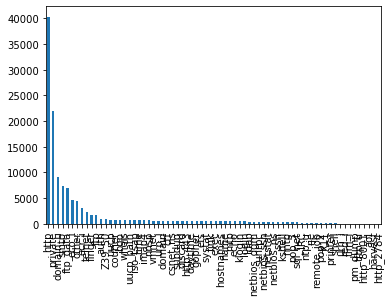

Showing feature flag


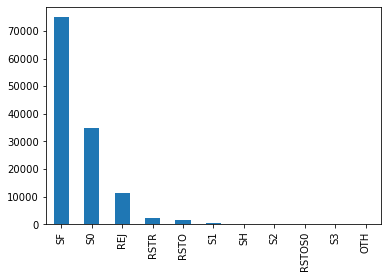

Showing feature src_bytes


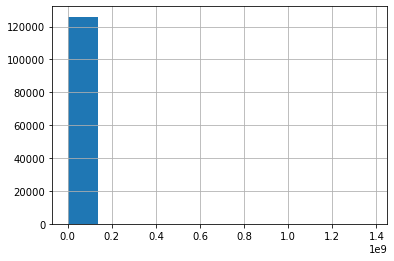

Showing feature dst_bytes


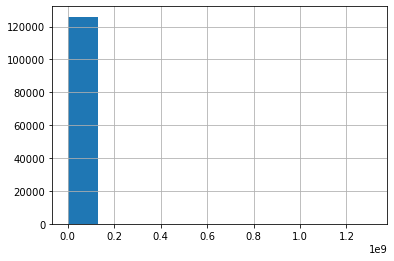

Showing feature land


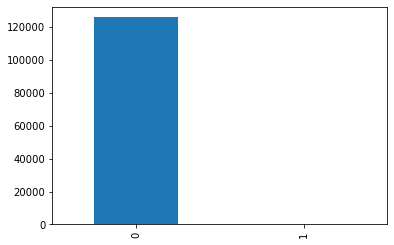

Showing feature wrong_fragment


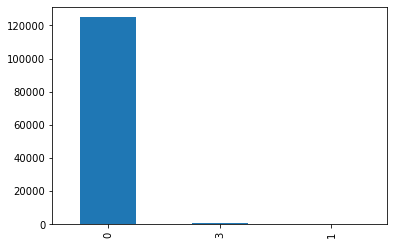

Showing feature urgent


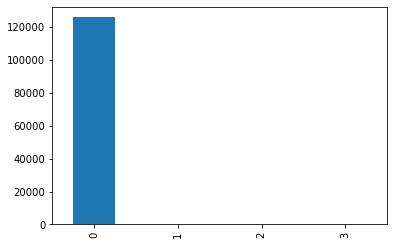

Showing feature hot


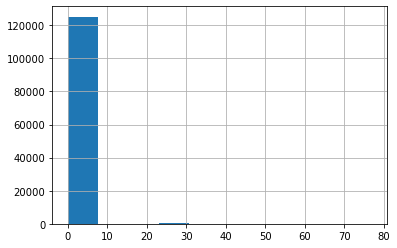

Showing feature num_failed_logins


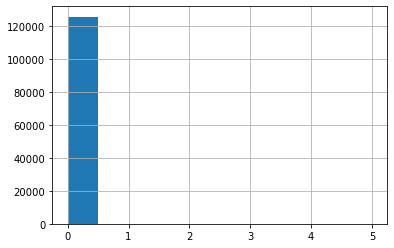

Showing feature logged_in


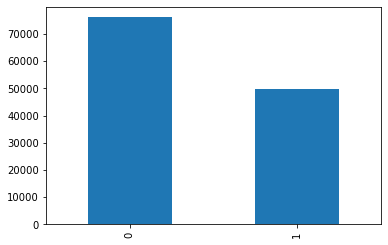

Showing feature num_compromised


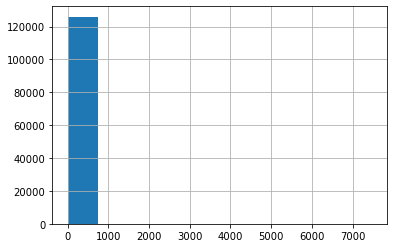

Showing feature root_shell


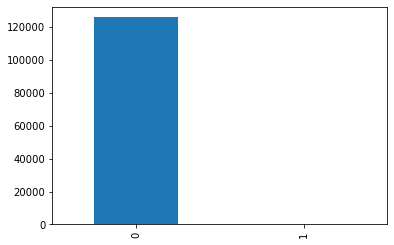

Showing feature su_attempted


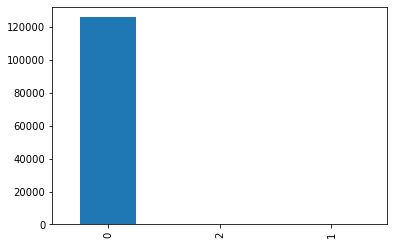

Showing feature num_root


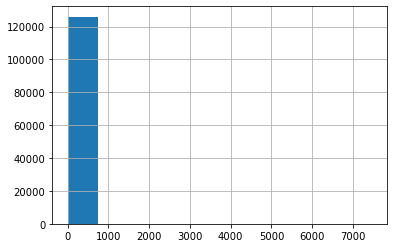

Showing feature num_file_creations


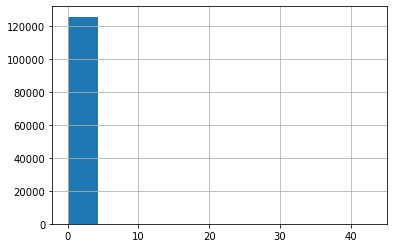

Showing feature num_shells


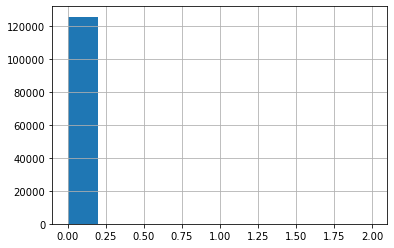

Showing feature num_access_files


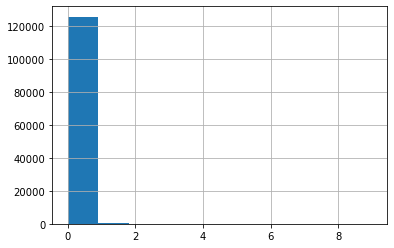

Showing feature num_outbound_cmds


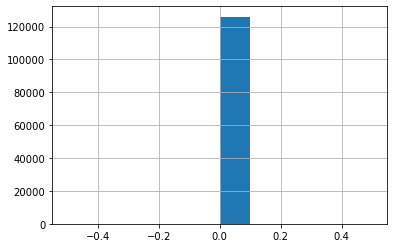

Showing feature is_host_login


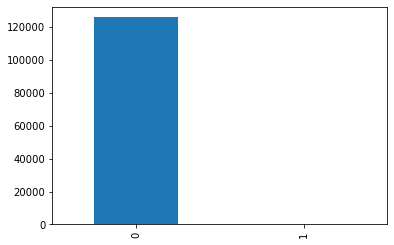

Showing feature is_guest_login


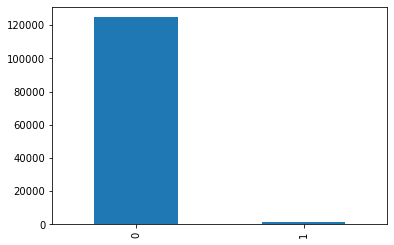

Showing feature count


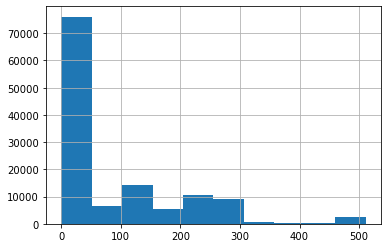

Showing feature srv_count


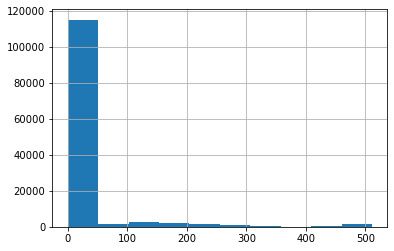

Showing feature serror_rate


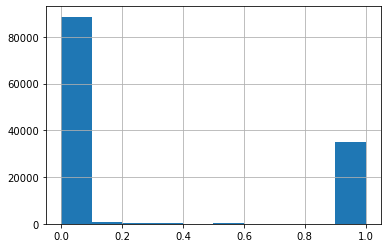

Showing feature srv_serror_rate


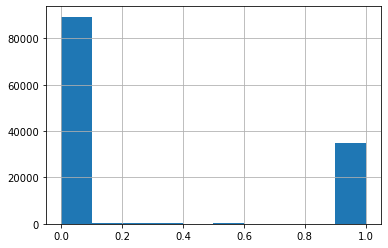

Showing feature rerror_rate


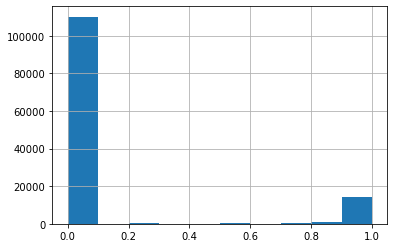

Showing feature srv_rerror_rate


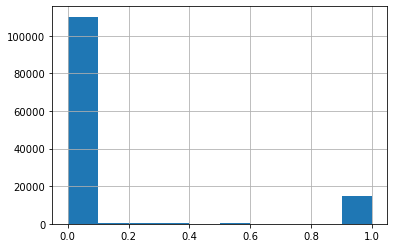

Showing feature same_srv_rate


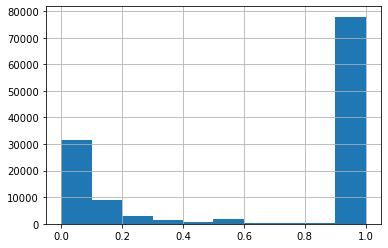

Showing feature diff_srv_rate


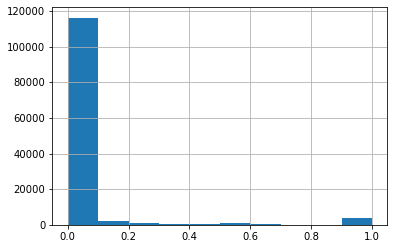

Showing feature srv_diff_host_rate


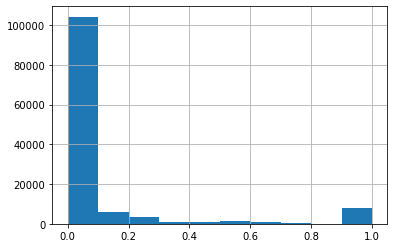

Showing feature dst_host_count


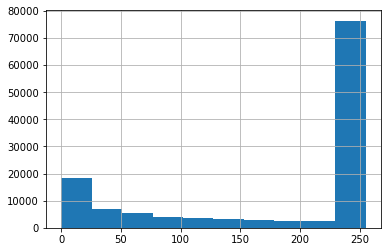

Showing feature dst_host_srv_count


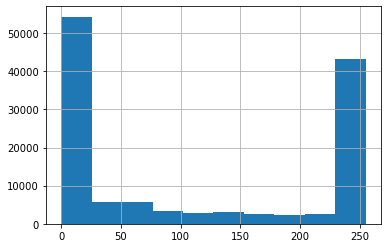

Showing feature dst_host_same_srv_rate


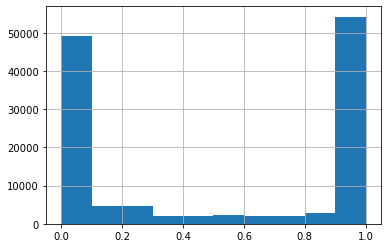

Showing feature dst_host_diff_srv_rate


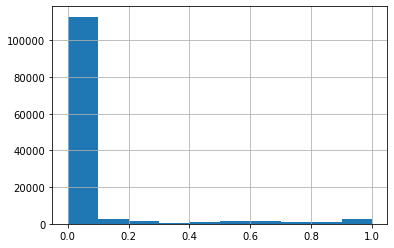

Showing feature dst_host_same_src_port_rate


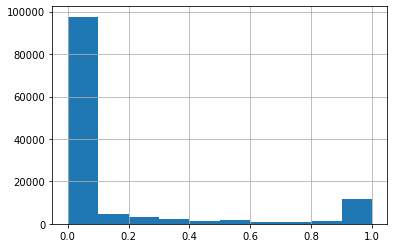

Showing feature dst_host_srv_diff_host_rate


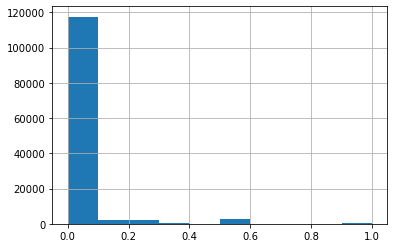

Showing feature dst_host_serror_rate


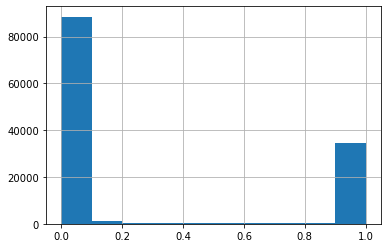

Showing feature dst_host_srv_serror_rate


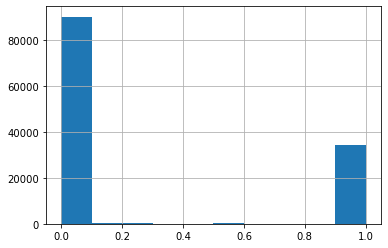

Showing feature dst_host_rerror_rate


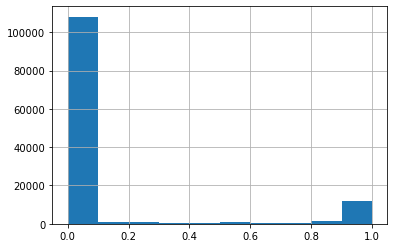

Showing feature dst_host_srv_rerror_rate


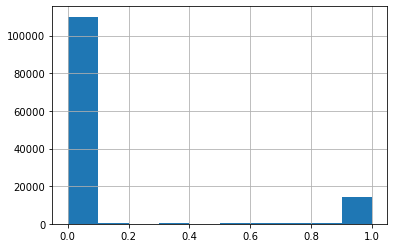

In [27]:
for i in range(len(features)):
    print("Showing feature %s" %(features[i]))
    if types[i] == "symbolic":
        data[features[i]].value_counts().plot(kind='bar')
    elif types[i] == "continuous":
        data[features[i]].hist()
    plt.show()

In [28]:
data["status"] = data["category"].map(lambda x: "normal" if x == "normal" else "attack")
#data["status"] = data["category"].map(lambda x: 0 if x == "normal" else 1)

In [29]:
uniq_status_cnt_df = data[["attack", "status"]].groupby("status").count().reset_index().rename(columns={"attack": "count"}).sort_values("count", ascending=False)

In [30]:
uniq_status_cnt_df

,status,count
1,normal,67343
0,attack,58630


In [31]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks,status
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20,normal,NaN,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15,normal,NaN,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19,dos,NaN,attack
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21,normal,NaN,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21,normal,NaN,normal


In [32]:
#pd.scatter_matrix(data, figsize=(10, 10))
#plt.show()

In [33]:
correlation_matrix = data.corr()

ct = 0.6
correlation_matrix_view = correlation_matrix[(((correlation_matrix <= -ct) | (correlation_matrix >= ct)) & (correlation_matrix < 1.0)).any()][((correlation_matrix <= -ct) | (correlation_matrix >= ct))].fillna(" ")
correlation_matrix_view

# High Correlations
# is_guest_login vs hot -> 0.860288
# num_root vs num_compromised -> 0.998833
# serror_rate vs srv_serror_rate -> 0.993289
# serror_rate vs dst_host_serror_rate -> 0.979373
# serror_rate vs dst_host_srv_serror_rate -> 0.981139

# rerror_rate vs srv_rerror_rate -> 0.989008
# rerror_rate vs dst_host_rerror_rate -> 0.926749
# rerror_rate vs dst_host_srv_rerror_rate -> 0.964449

# dst_host_srv_count vs dst_host_same_srv_rate -> 0.896663
# dst_host_serror_rate vs dst_host_srv_serror_rate -> 0.985052

# Remove the following 
# hot, num_compromised, srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate
# srv_rerror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate, 
# dst_host_same_srv_rate, dst_host_srv_serror_rate

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,cnt_correct
hot,,,,,,,1,,,,,,,,,,,,0.860288,,,,,,,,,,,,,,,,,,,,
logged_in,,,,,,,,,1,,,,,,,,,,,,,,,,,0.600536,,,,0.624365,0.604058,,,,,,,,
num_compromised,,,,,,,,,,1,,,0.998833,,,,,,,,,,,,,,,,,,,,,,,,,,
root_shell,,,,,,,,,,,1,0.609083,,,,,,,,,,,,,,,,,,,,,,,,,,,
su_attempted,,,,,,,,,,,0.609083,1,,,,,,,,,,,,,,,,,,,,,,,,,,,
num_root,,,,,,,,,,0.998833,,,1,,,,,,,,,,,,,,,,,,,,,,,,,,
is_guest_login,,,,,,,0.860288,,,,,,,,,,,,1,,,,,,,,,,,,,,,,,,,,
count,,,,,,,,,,,,,,,,,,,,1,,,,,,-0.628024,,,,,,,,,,,,,
serror_rate,,,,,,,,,,,,,,,,,,,,,,1,0.993289,,,-0.761888,,,,,-0.622797,,,,0.979373,0.981139,,,
srv_serror_rate,,,,,,,,,,,,,,,,,,,,,,0.993289,1,,,-0.756784,,,,,-0.61913,,,,0.977596,0.986252,,,


In [34]:
correlation_list = correlation_matrix.columns
correlation_threshold = 0.6
possible_remove_list = []

for col in correlation_list:
    for col2 in correlation_list:
        if col != col2:
            correlation_val = correlation_matrix.loc[col, col2]
            if correlation_val >= correlation_threshold or correlation_val <= -correlation_threshold:
                print(col, col2, correlation_val)
                if col not in possible_remove_list:
                    possible_remove_list.append(col)
                if col2 not in possible_remove_list:
                    possible_remove_list.append(col2)

hot is_guest_login 0.8602881047178712
logged_in same_srv_rate 0.6005357192354351
logged_in dst_host_srv_count 0.624364604369109
logged_in dst_host_same_srv_rate 0.60405830600257
num_compromised num_root 0.998833452578241
root_shell su_attempted 0.6090834457113253
su_attempted root_shell 0.6090834457113253
num_root num_compromised 0.998833452578241
is_guest_login hot 0.8602881047178712
count same_srv_rate -0.6280240516792714
serror_rate srv_serror_rate 0.993289242538446
serror_rate same_srv_rate -0.7618875139504406
serror_rate dst_host_same_srv_rate -0.6227973221645197
serror_rate dst_host_serror_rate 0.9793730829859216
serror_rate dst_host_srv_serror_rate 0.9811389586199488
srv_serror_rate serror_rate 0.993289242538446
srv_serror_rate same_srv_rate -0.7567840292324389
srv_serror_rate dst_host_same_srv_rate -0.6191298270895028
srv_serror_rate dst_host_serror_rate 0.9775960119668284
srv_serror_rate dst_host_srv_serror_rate 0.9862517164947782
rerror_rate srv_rerror_rate 0.9890076529818336

In [35]:
possible_remove_list

['hot',
 'is_guest_login',
 'logged_in',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'num_compromised',
 'num_root',
 'root_shell',
 'su_attempted',
 'count',
 'serror_rate',
 'srv_serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [36]:
impt_cols = ["src_bytes", "dst_bytes", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
             "dst_host_count", "dst_host_srv_count", "count", "duration"]

remove_list = []

for col in possible_remove_list:
    if col not in impt_cols:
        remove_list.append(col)

In [37]:
remove_list

['hot',
 'is_guest_login',
 'logged_in',
 'same_srv_rate',
 'dst_host_same_srv_rate',
 'num_compromised',
 'num_root',
 'root_shell',
 'su_attempted',
 'serror_rate',
 'srv_serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [38]:
column_val = correlation_matrix_view.columns
index_val = correlation_matrix_view.index

In [39]:
correlation_matrix_view[index_val]

,hot,logged_in,num_compromised,root_shell,su_attempted,num_root,is_guest_login,count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,dst_host_srv_count,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
hot,1,,,,,,0.860288,,,,,,,,,,,,
logged_in,,1,,,,,,,,,,,0.600536,0.624365,0.604058,,,,
num_compromised,,,1,,,0.998833,,,,,,,,,,,,,
root_shell,,,,1,0.609083,,,,,,,,,,,,,,
su_attempted,,,,0.609083,1,,,,,,,,,,,,,,
num_root,,,0.998833,,,1,,,,,,,,,,,,,
is_guest_login,0.860288,,,,,,1,,,,,,,,,,,,
count,,,,,,,,1,,,,,-0.628024,,,,,,
serror_rate,,,,,,,,,1,0.993289,,,-0.761888,,-0.622797,0.979373,0.981139,,
srv_serror_rate,,,,,,,,,0.993289,1,,,-0.756784,,-0.61913,0.977596,0.986252,,


In [40]:
correlation_matrix

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,cnt_correct
duration,1.000000,0.070737,0.034878,-0.001553,-0.009866,0.003830,0.000705,0.009528,-0.064218,0.042679,0.052791,0.087183,0.045519,0.099116,-0.001593,0.070420,NaN,-0.000258,0.000440,-0.079042,-0.039470,-0.069873,-0.069510,0.200682,0.199961,0.074681,-0.013738,-0.040158,0.050570,-0.109776,-0.116005,0.254195,0.228737,-0.026669,-0.064948,-0.064361,0.173815,0.199024,-0.156311
src_bytes,0.070737,1.000000,0.000204,-0.000109,-0.000693,-0.000059,0.000295,-0.000208,-0.003353,-0.000086,-0.000272,-0.000186,-0.000093,-0.000179,-0.000134,-0.000309,NaN,-0.000022,-0.000742,-0.005152,-0.002792,-0.003228,-0.003438,0.013782,0.013975,0.003899,-0.000432,-0.002608,-0.005791,-0.006861,-0.006572,0.000900,0.000431,-0.001655,-0.004503,-0.003397,-0.001468,0.012449,-0.022592
dst_bytes,0.034878,0.000204,1.000000,-0.000069,-0.000440,0.000248,-0.000344,0.000504,-0.002894,0.001233,0.001069,0.001133,0.001229,0.000089,-0.000083,0.000339,NaN,-0.000008,-0.000421,-0.003543,-0.001754,-0.003059,-0.003038,0.011176,0.011052,0.003788,-0.001703,-0.001674,0.002528,-0.004224,-0.004424,0.011031,0.011747,-0.001281,-0.003024,-0.002944,0.011729,0.011223,-0.018076
land,-0.001553,-0.000109,-0.000069,1.000000,-0.001261,-0.000109,-0.001340,-0.000381,-0.011402,-0.000164,-0.000516,-0.000344,-0.000174,-0.000369,-0.000262,-0.000581,NaN,-0.000040,-0.001374,-0.009837,-0.005031,0.021734,0.022614,-0.004096,-0.005275,0.008739,-0.001551,0.038102,-0.025499,-0.014159,0.011597,-0.004516,0.033851,0.070474,0.019840,0.012276,-0.005222,-0.005303,-0.037038
wrong_fragment,-0.009866,-0.000693,-0.000440,-0.001261,1.000000,-0.000692,-0.008508,-0.002418,-0.072418,-0.001044,-0.003280,-0.002187,-0.001108,-0.002343,-0.001665,-0.003689,NaN,-0.000252,-0.008728,-0.020819,0.024457,-0.043316,-0.056549,-0.033052,-0.033507,0.054759,-0.026638,-0.026247,0.041056,-0.045240,-0.048733,0.059797,0.037177,-0.016252,-0.051917,-0.055917,0.028890,-0.033682,-0.157130
urgent,0.003830,-0.000059,0.000248,-0.000109,-0.000692,1.000000,0.000293,0.097507,0.007299,0.033329,0.075199,0.097710,0.032470,0.024918,-0.000144,0.010803,NaN,-0.000022,-0.000754,-0.005615,-0.002848,-0.004929,-0.004889,-0.002896,-0.002897,0.005967,-0.002705,-0.002898,-0.006941,-0.007897,-0.004489,0.006840,0.002741,0.005176,-0.004749,-0.004834,-0.002999,-0.002912,-0.016411
hot,0.000705,0.000295,-0.000344,-0.001340,-0.008508,0.000293,1.000000,0.003715,0.116435,0.002014,0.015379,0.000130,0.001510,0.028716,0.004723,-0.001987,NaN,0.001043,0.860288,-0.068697,-0.034575,-0.059083,-0.058713,-0.032382,-0.031436,0.069365,-0.016212,-0.026781,-0.012249,-0.051864,-0.036293,-0.012293,-0.034536,-0.024715,-0.058222,-0.058214,-0.030555,-0.031670,-0.160013
num_failed_logins,0.009528,-0.000208,0.000504,-0.000381,-0.002418,0.097507,0.003715,1.000000,-0.006439,0.019085,0.032567,0.073175,0.018112,0.021774,-0.000503,0.000652,NaN,-0.000076,0.006446,-0.019544,-0.009880,-0.015254,-0.015899,0.022193,0.021870,0.019477,-0.004438,-0.010122,-0.025476,-0.023053,-0.001576,-0.001945,-0.005526,0.003302,-0.011648,-0.012299,0.018660,0.017359,-0.073178
logged_in,-0.064218,-0.003353,-0.002894,-0.011402,-0.072418,0.007299,0.116435,-0.006439,1.000000,0.014413,0.045290,0.030196,0.015304,0.032283,0.022996,0.050937,NaN,0.003482,0.119678,-0.539754,-0.199744,-0.491925,-0.490167,-0.287514,-0.283532,0.600536,-0.221323,0.131074,-0.401084,0.624365,0.604058,-0.256065,-0.160994,-0.055953,-0.491478,-0.493264,-0.275972,-0.272806,0.26981

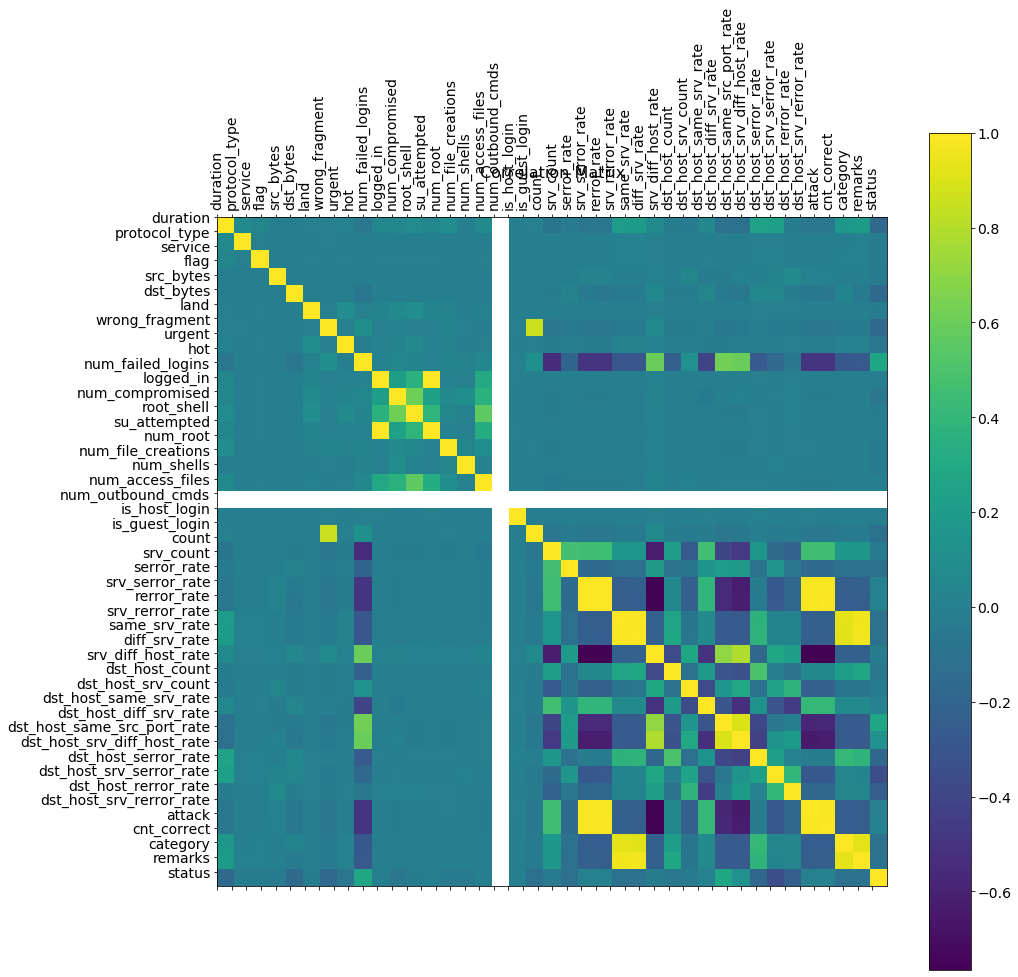

In [41]:
extent_max = len(data.columns)

f = plt.figure(figsize=(15, 15))
plt.matshow(data.corr(), fignum=f.number, extent=[0, extent_max, extent_max, 0])
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [42]:
target = ["category"] #["category"] -> Attack Type or ["status"] -> Normal or Attack

In [43]:
#data = data[(data["category"] == "normal") | (data["category"] == "dos") | (data["category"] == "probe")]

In [44]:
#features = ['src_bytes','dst_bytes','dst_host_diff_srv_rate','dst_host_count','dst_host_serror_rate',
#            'dst_host_rerror_rate','protocol_type','service','flag','land','wrong_fragment','urgent',
#            'logged_in','root_shell','su_attempted','is_host_login','is_guest_login']

In [45]:
X_train = data[features]

In [46]:
y_train = data[target]

In [47]:
print("Training Set shape", X_train.shape)

Training Set shape (125973, 41)


In [48]:
# Don't remove those features from the remove_list yet because i don't want to mess up the ordering for the resampling

# Resampling the dataset

In [49]:
categorical_cols_index = field_names[field_names["type"] == "symbolic"].index
categorical_cols_index = categorical_cols_index[:-1] # Removing 1 for the added "attack" symbolic column
categorical_cols_index

Int64Index([1, 2, 3, 6, 7, 8, 11, 13, 14, 20, 21], dtype='int64')

In [50]:
# When rerunning the resampling
#features = list(field_names["header"])
#features.remove("attack")
#features.remove("cnt_correct")

In [51]:
#resample_dict = {"normal":70000, "dos":70000, "probe":70000, "r2l":70000, "u2r":70000} #{"probe":15000, "r2l":2000, "u2r":2000}
#resample_dict = {"probe":45000, "r2l":45000, "u2r":45000} 
resample_dict = {"r2l":11000, "u2r":11000} 
#resample_dict = {"u2r":5000}


imbl_obj = imblearn.over_sampling.SMOTENC(categorical_cols_index, resample_dict, random_state=0)

In [52]:
data_resampled = imbl_obj.fit_sample(X_train, y_train)

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
data_resampled

(array([[0.0, 'tcp', 'ftp_data', ..., 0.0, 0.05, 0.0],
        [0.0, 'udp', 'other', ..., 0.0, 0.0, 0.0],
        [0.0, 'tcp', 'private', ..., 1.0, 0.0, 0.0],
        ...,
        [163.08903410052696, 'tcp', 'telnet', ..., 0.0, 0.0, 0.0],
        [47.59621124914659, 'tcp', 'ftp_data', ..., 0.0,
         0.49095713756542797, 0.0],
        [30.981605044662523, 'tcp', 'telnet', ..., 0.0, 0.0, 0.0]],
       dtype=object),
 array(['normal', 'normal', 'dos', ..., 'u2r', 'u2r', 'u2r'], dtype=object))

In [54]:
data_resampled_df = pd.DataFrame(data=data_resampled[0], columns=features)

In [55]:
data_resampled_df[target[0]] = data_resampled[1]

In [56]:
data_resampled_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,1,0,0,150,25,0.17,0.03,0.17,0,0,0,0.05,0,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0,0,0,0,0.08,0.15,0,255,1,0,0.6,0.88,0,0,0,0,0,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1,1,0,0,0.05,0.07,0,255,26,0.1,0.05,0,0,1,1,0,0,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0,0,1,0,0,30,255,1,0,0.03,0.04,0.03,0.01,0,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0,0,0,0,1,0,0.09,255,255,1,0,0,0,0,0,0,0,normal


In [57]:
data_resampled_df[["duration", "category"]].groupby("category").count().reset_index().rename(columns={"duration": "count"}).sort_values("count", ascending=False)

,category,count
1,normal,67343
0,dos,45927
2,probe,11656
3,r2l,11000
4,u2r,11000


In [59]:
# If we are not resampling the dataset, just assign it to the other dataset

resampling = "Y"

if resampling == "N":
    X_train[target[0]] = y_train
    data_resampled_df = X_train

elif resampling == "Y":
    data_resampled_df = data_resampled_df

In [60]:
X_train_resampled = data_resampled_df[features]

In [61]:
X_train_resampled.shape

(125973, 41)

In [62]:
Y_train_resampled = data_resampled_df[target]

In [63]:
Y_train_resampled.shape

(125973, 1)

# Processing the Training Data

In [64]:
# Dropping columns which have no extra data. all is 0
drop_cols = ["num_outbound_cmds"]

#drop_cols = ["num_outbound_cmds", "hot", "num_compromised", "srv_serror_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
#"srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "dst_host_same_srv_rate", "dst_host_srv_serror_rate"]

# from (part 2)
#drop_cols = ["num_outbound_cmds", "hot", "num_compromised", "srv_serror_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate", 
#"srv_rerror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "dst_host_same_srv_rate", "dst_host_srv_serror_rate",
#"flag_SF", "logged_in_1", "flag_S0", "flag_REJ"]

#drop_cols = ['num_outbound_cmds', 'hot', 'is_guest_login','logged_in', 'same_srv_rate',  
#             'dst_host_same_srv_rate', 'num_compromised', 'num_root', 'root_shell', 'su_attempted', 
#             'serror_rate', 'srv_serror_rate', 'dst_host_serror_rate','dst_host_srv_serror_rate', 'rerror_rate', 
#             'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

In [65]:
dataframe = X_train_resampled
for drop_col in drop_cols:
    if drop_col in dataframe.columns:
        print("Dropping column: %s" %(drop_col))
        dataframe = dataframe.drop(drop_col, axis=1)
    else:
        pass

X_train_resampled = dataframe

Dropping column: num_outbound_cmds


In [66]:
X_train_resampled.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.00,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01
4,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [67]:
for drop_col in drop_cols:
    if drop_col in features:
        print("Removing feature: %s" %(drop_col))
        features.remove(drop_col)
    else:
        pass

Removing feature: num_outbound_cmds


In [68]:
# Replace the following columns with the log of themselves
log_cols = ["duration", "src_bytes", "dst_bytes", "hot", "num_failed_logins", "num_compromised", "num_root", "num_file_creations", 
            "num_shells", "num_access_files"]

dataframe = X_train_resampled

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

X_train_log_transformed = dataframe  

Processing column: duration


D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [69]:
numeric_cols = list(field_names["header"][field_names["type"] == "continuous"])
numeric_cols.remove("num_outbound_cmds")

In [70]:
numeric_cols

['duration',
 'src_bytes',
 'dst_bytes',
 'hot',
 'num_failed_logins',
 'num_compromised',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [71]:
# Normalizing the values
dataframe = X_train_log_transformed
norm_type = "mean-std"

for numeric_col in numeric_cols:
    if numeric_col in dataframe.columns:
        print("Processing column: %s" %(numeric_col))
        values = dataframe[numeric_col]
        if norm_type == "min-max":
            dataframe[numeric_col] = (values - np.min(values))/(np.max(values) - np.min(values))
            dataframe[numeric_col] = dataframe[numeric_col].astype("float")
        elif norm_type == "mean-std":
            dataframe[numeric_col] = (values - np.min(values))/np.std(values)
            dataframe[numeric_col] = dataframe[numeric_col].astype("float")
    else:
        pass
    
X_train_normalized = dataframe

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Processing column: dst_host_rerror_rate
Processing column: dst_

In [72]:
X_train_normalized.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,tcp,ftp_data,SF,2.068858,0.000000,0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.017466,0.027535,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.000000,1.512008,0.225831,0.378663,0.158796,0.550169,0.000000,0.000000,0.000000,0.163102,0.000000
1,0.0,udp,other,SF,1.663918,0.000000,0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.113529,0.013767,0.000000,0.000000,0.0,0.0,0.181975,0.831884,0.000000,2.570414,0.009033,0.000000,3.175930,2.847934,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.0,tcp,private,S0,0.000000,0.000000,0,0,0,0.0,0.0,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0,1.074159,0.082604,2.239873,2.237033,0.0,0.0,0.113734,0.388212,0.000000,2.570414,0.234864,0.222743,0.264661,0.000000,0.000000,2.248291,2.243826,0.000000,0.000000
3,0.0,tcp,http,SF,1.818547,2.537965,0,0,0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.043665,0.068837,0.447975,0.447407,0.0,0.0,2.274686,0.000000,0.000000,0.302402,2.303475,2.227432,0.000000,0.097089,0.355355,0.067449,0.022438,0.000000,0.031303
4,0.0,tcp,http,SF,1.767319,1.702167,0,0,0,0.0,0.0,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0,0.261990,0.440556,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.346381,2.570414,2.303475,2.227432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
"""
# Select Features based on their variance (Was not useful)
numeric_cols = list(field_names["header"][field_names["type"] == "continuous"])
numeric_cols.remove("num_outbound_cmds")

variance_threshold = 0.7
dataset = X_train_resampled


selector = VarianceThreshold(variance_threshold)
selector = selector.fit(dataset[numeric_cols])

categorical_cols = list(field_names["header"][field_names["type"] == "symbolic"])
categorical_cols.remove("attack")

features = list(dataset[numeric_cols].columns[selector.get_support(indices=True)]) + categorical_cols
features
"""

'\n# Select Features based on their variance (Was not useful)\nnumeric_cols = list(field_names["header"][field_names["type"] == "continuous"])\nnumeric_cols.remove("num_outbound_cmds")\n\nvariance_threshold = 0.7\ndataset = X_train_resampled\n\n\nselector = VarianceThreshold(variance_threshold)\nselector = selector.fit(dataset[numeric_cols])\n\ncategorical_cols = list(field_names["header"][field_names["type"] == "symbolic"])\ncategorical_cols.remove("attack")\n\nfeatures = list(dataset[numeric_cols].columns[selector.get_support(indices=True)]) + categorical_cols\nfeatures\n'

In [74]:
X_train_normalized.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,0.210445,1.071049,0.868449,0.000198,0.022687,0.000111,0.113815,0.011398,0.395736,0.037190,0.001342,0.001103,0.045984,0.029037,0.006300,0.019635,0.000008,0.009423,0.734511,0.381878,0.637209,0.631929,0.374362,0.374432,1.503403,0.349683,0.374560,1.836071,1.044721,1.161030,0.439078,0.480197,0.289103,0.639532,0.624871,0.387635,0.376387
std,1.000004,1.000004,1.000004,0.014086,0.253530,0.014366,1.000004,1.000004,0.489010,1.000004,0.036603,0.045154,1.000004,1.000004,1.000004,1.000004,0.002817,0.096612,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004,1.000004
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017466,0.027535,0.000000,0.000000,0.000000,0.000000,0.204722,0.000000,0.000000,0.826564,0.090332,0.111372,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.263459,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122262,0.110139,0.000000,0.000000,0.000000,0.000000,2.274686,0.000000,0.000000,2.570414,0.569094,1.135990,0.105864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.876530,1.760177,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.248819,0.247813,2.239873,2.237033,0.000000,0.000000,2.274686,0.332753,0.000000,2.570414,2.303475,2.227432,0.370525,0.194177,0.177678,2.248291,2.243826,0.000000,0.000000
max,7.375881,7.026576,5.915977,1.000000,3.000000,3.000000,15.409231,132.053980,1.000000,61.127279,1.000000,2.000000,54.472675,53.553212,158.731219,83.647190,1.000000,1.000000,4.462564,7.035122,2.239873,2.237033,3.120765,3.089796,2.274686,5.545891,3.848678,2.570414,2.303475,2.227432,5.293216,3.236289,8.883886,2.248291,2.243826,3.262044,3.130301


In [75]:
X_train_normalized.shape

(125973, 40)

In [76]:
categorical_cols = list(field_names["header"][field_names["type"] == "symbolic"])
categorical_cols.remove("attack")

In [77]:
categorical_cols

['protocol_type',
 'service',
 'flag',
 'land',
 'wrong_fragment',
 'urgent',
 'logged_in',
 'root_shell',
 'su_attempted',
 'is_host_login',
 'is_guest_login']

In [78]:
dataframe = X_train_normalized

for col in categorical_cols:
    if col in dataframe.columns:
        print(col, dataframe[col].unique())

protocol_type ['tcp' 'udp' 'icmp']
service ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']
flag ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
land [0 1]
wrong_fragment [0 3 1]
urgent [0 1 3 2]
logged_in [0 1]
root_shell [0 1]
su_attempted [0 1 2]
is_host_login [0 1]
is_guest_login [0 1]


In [79]:
dataframe = X_train_normalized

categorical_in_dataset = []
for col in categorical_cols:
    if col in dataframe.columns:
        categorical_in_dataset.append(col)

X_train_resampled_encoded = pd.get_dummies(dataframe, columns=categorical_in_dataset)

In [80]:
X_train_resampled_encoded.head()

,duration,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_0,land_1,wrong_fragment_0,wrong_fragment_1,wrong_fragment_3,urgent_0,urgent_1,urgent_2,urgent_3,logged_in_0,logged_in_1,root_shell_0,root_shell_1,su_attempted_0,su_attempted_1,su_attempted_2,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
0,0.0,2.068858,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017466,0.027535,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.000000,1.512008,0.225831,0.378663,0.158796,0.550169,0.000000,0.000000,0.000000,0.163102,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
1,0.0,1.663918,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113529,0.013767,0.000000,0.000000,0.0,0.0,0.181975,0.831884,0.000000,2.570414,0.009033,0.000000,3.175930,2.847934,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.074159,0.082604,2.239873,2.237033,0.0,0.0,0.113734,0.388212,0.000000,2.570414,0.234864,0.222743,0.264661,0.000000,0.000000,2.248291,2.243826,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
3,0.0,1.818547,2.537965,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043665,0.068837,0.447975,0.447407,0.0,0.0,2.274686,0.000000,0.000000,0.302402,2.303475,2.227432,0.000000,0.097089,0.355355,0.067449,0.022438,0.000000,0.031303,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0
4,0.0,1.767319,1.702167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.261990,0.440556,0.000000,0.000000,0.0,0.0,2.274686,0.000000,0.346381,2.570414,2.303475,2.227432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0

In [82]:
X_train_resampled_encoded.shape

(125973, 133)

# Training the Model(s)

In [83]:
rfc = RandomForestClassifier(max_depth=5, max_features="log2", random_state=0)

In [84]:
rfc_clf = rfc.fit(X_train_resampled_encoded, Y_train_resampled)

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [85]:
rfc_clf.score(X_train_resampled_encoded, Y_train_resampled)

0.9595945162852357

In [86]:
xgbc = xgboost.XGBClassifier(base_score = 0.75, max_depth=5, learning_rate=0.05, reg_lambda=2, random_state=0, n_jobs=-1)

In [87]:
xgbc_clf = xgbc.fit(X_train_resampled_encoded, Y_train_resampled)

D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [88]:
xgbc_clf.score(X_train_resampled_encoded, Y_train_resampled)

0.9985552459654052

In [89]:
rfc_clf1 = RandomForestClassifier(max_depth=5, max_features="log2", random_state=0)
xgbc_clf1 = xgboost.XGBClassifier(max_depth=5, learning_rate=0.05, reg_lambda=2, random_state=0, n_jobs=-1)
xgbc_clf2 = xgboost.XGBClassifier(max_depth=5, learning_rate=0.05, reg_lambda=2, random_state=1, n_jobs=-1)
xgbc_clf3 = xgboost.XGBClassifier(max_depth=5, learning_rate=0.05, reg_lambda=2, random_state=3, n_jobs=-1)


voting_clf = VotingClassifier(estimators=[('xgb1', xgbc_clf1), ('xgb2', xgbc_clf2), ('xgb3', xgbc_clf3)],
                              voting='soft', weights=[1,2,2],flatten_transform=True)

In [90]:
voting_clf = voting_clf.fit(X_train_resampled_encoded, Y_train_resampled)

In [91]:
voting_clf.score(X_train_resampled_encoded, Y_train_resampled)

0.9985552459654052

In [92]:
rfc_clf.feature_importances_

array([1.25224232e-03, 7.21630357e-02, 1.21907680e-04, 0.00000000e+00,
       0.00000000e+00, 2.47439696e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.27307591e-01, 2.20169856e-02,
       2.81466630e-03, 4.27313730e-03, 1.17240167e-03, 2.35957999e-03,
       1.98655070e-02, 5.69439006e-02, 1.93522664e-03, 9.31059331e-03,
       1.22321037e-02, 1.31373827e-03, 6.10496281e-02, 4.05738386e-02,
       5.29362130e-02, 1.49288259e-01, 8.56082911e-03, 5.12479328e-03,
       2.01511090e-02, 2.81298545e-02, 1.79683937e-03, 5.90828298e-04,
       0.00000000e+00, 1.83555383e-05, 9.74594638e-04, 0.00000000e+00,
       1.46483068e-06, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       6.47745266e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       2.80250713e-03, 0.00000000e+00, 1.86441104e-02, 4.70959904e-03,
       0.00000000e+00, 0.00000000e+00, 3.74155831e-04, 5.05474181e-05,
       2.52190952e-05, 6.47880445e-04, 0.00000000e+00, 3.60322157e-05,
      

In [93]:
X_train_resampled_encoded.columns

Index(['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins',
       'num_compromised', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files',
       ...
       'logged_in_1', 'root_shell_0', 'root_shell_1', 'su_attempted_0',
       'su_attempted_1', 'su_attempted_2', 'is_host_login_0',
       'is_host_login_1', 'is_guest_login_0', 'is_guest_login_1'],
      dtype='object', length=133)

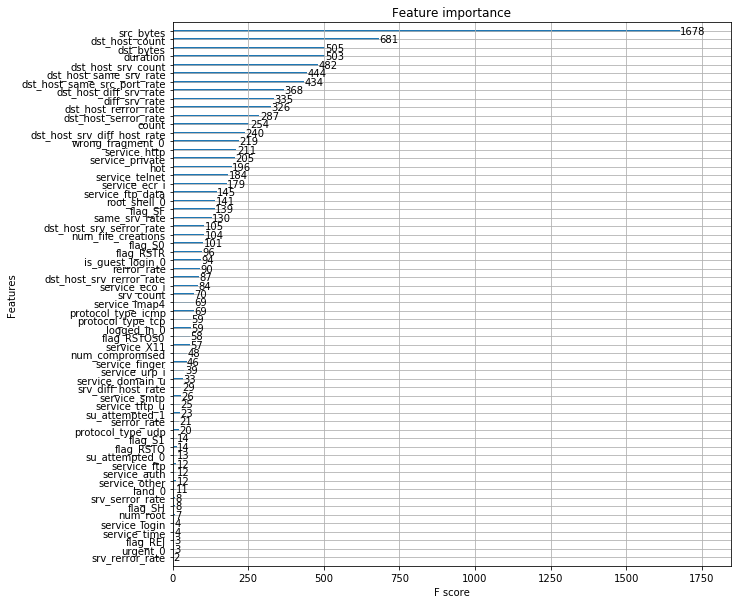

In [94]:
ax = xgboost.plot_importance(xgbc_clf)
fig = ax.figure
fig.set_size_inches(10, 10)

impt_cols = ["src_bytes", "dst_bytes", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", 
             "dst_host_count", "dst_host_srv_count", "count", "duration"]

# Preprocessing the  Test Data

In [95]:
test_df = pd.read_csv("KDDTest+.txt", names=list(field_names["header"]))
test_df = pd.merge(test_df, attack_types, on="attack", how="left")

In [96]:
test_df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,229,10,0.0,0.00,1.0,1.0,0.04,0.06,0.00,255,10,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos,NaN
1,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.00,1.0,1.0,0.01,0.06,0.00,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,dos,NaN
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.00,0.0,0.0,1.00,0.00,0.00,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,normal,NaN
3,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.00,0.0,0.0,1.00,0.00,1.00,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,probe,added (not in training set)
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,0.0,0.12,1.0,0.5,1.00,0.00,0.75,29,86,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,probe,added (not in training set)


In [97]:
#test_df = test_df[(test_df["category"] == "normal") | (test_df["category"] == "dos") | (test_df["category"] == "probe")]

In [98]:
test_df["status"] = test_df["category"].map(lambda x: "normal" if x == "normal" else "attack")
#test_df["status"] = test_df["category"].map(lambda x: 0 if x == "normal" else 1)

In [99]:
uniq_category_cnt_test_df = test_df[["attack", "category"]].groupby("category").count().reset_index().rename(columns={"attack": "count"}).sort_values("count", ascending=False)

In [100]:
uniq_category_cnt_test_df

,category,count
1,normal,9711
0,dos,7458
3,r2l,2754
2,probe,2421
4,u2r,200


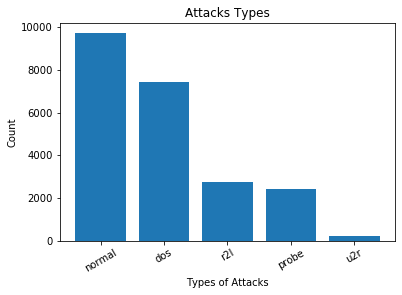

In [101]:
label = uniq_category_cnt_test_df["category"]

index = np.arange(len(label))
plt.bar(label, uniq_category_cnt_test_df["count"])
plt.xlabel('Types of Attacks', fontsize=10)
plt.ylabel('Count', fontsize=10)
plt.xticks(index, label, fontsize=10, rotation=30)
plt.title('Attacks Types')
plt.show()

In [102]:
# There are nulls
test_df[test_df[target[0]].isna()]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks,status


In [103]:
test_df[test_df["category"].isna()]["attack"].unique()

array([], dtype=object)

In [104]:
#test_df = test_df.fillna("unknown") # This will come back to bite me later
#test_df["category"] = test_df["category"].map(lambda x: "dos" if x == "unknown" else x)

In [105]:
# There are no more nulls
test_df[test_df[target[0]].isna()]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,cnt_correct,category,remarks,status


In [106]:
print("features are", features)
print("target is ", target)

features are ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
target is  ['category']


In [107]:
X_test = test_df[features]
Y_test = test_df[target]

In [108]:
# Replace the following columns with the log of themselves
dataframe = X_test

for log_col in log_cols:
    if log_col in dataframe.columns:
        print("Processing column: %s" %(log_col))
        dataframe[log_col] = dataframe[log_col].map(lambda x: max(np.log(x), 0))
    else:
        pass

X_test_log_transformed = dataframe  

Processing column: duration
Processing column: src_bytes
Processing column: dst_bytes


D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files


In [109]:
# Normalizing the values
dataframe = X_test_log_transformed

print("Using the norm_type set above: %s \n" %(norm_type))

for numeric_col in numeric_cols:
    if numeric_col in dataframe.columns:
        print("Processing column: %s" %(numeric_col))
        values = dataframe[numeric_col]
        if norm_type == "min-max":
            dataframe[numeric_col] = (values - np.min(values))/(np.max(values) - np.min(values))
            dataframe[numeric_col] = dataframe[numeric_col].astype("float")
        elif norm_type == "mean-std":
            dataframe[numeric_col] = (values - np.min(values))/np.std(values)
            dataframe[numeric_col] = dataframe[numeric_col].astype("float")
    else:
        pass
    
X_test_normalized = dataframe

Using the norm_type set above: mean-std 

Processing column: duration
Processing column: src_bytes


D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Processing column: dst_bytes
Processing column: hot
Processing column: num_failed_logins
Processing column: num_compromised
Processing column: num_root
Processing column: num_file_creations
Processing column: num_shells
Processing column: num_access_files
Processing column: count
Processing column: srv_count
Processing column: serror_rate
Processing column: srv_serror_rate
Processing column: rerror_rate
Processing column: srv_rerror_rate
Processing column: same_srv_rate
Processing column: diff_srv_rate
Processing column: srv_diff_host_rate
Processing column: dst_host_count
Processing column: dst_host_srv_count
Processing column: dst_host_same_srv_rate
Processing column: dst_host_diff_srv_rate
Processing column: dst_host_same_src_port_rate
Processing column: dst_host_srv_diff_host_rate
Processing column: dst_host_serror_rate
Processing column: dst_host_srv_serror_rate
Processing column: dst_host_rerror_rate
Processing column: dst_host_srv_rerror_rate


In [110]:
for col in categorical_cols:
    if col in X_test.columns:
        print(col, X_train[col].unique())
        tmp_dtype = pd.api.types.CategoricalDtype(categories = X_train[col].unique())
        X_test[col] = X_test[col].astype(tmp_dtype)

protocol_type ['tcp' 'udp' 'icmp']
service ['ftp_data' 'other' 'private' 'http' 'remote_job' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']
flag ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']
land [0 1]


D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


wrong_fragment [0 3 1]
urgent [0 1 3 2]
logged_in [0 1]
root_shell [0 1]
su_attempted [0 1 2]
is_host_login [0 1]
is_guest_login [0 1]


In [111]:
categorical_in_dataset = []
for col in categorical_cols:
    if col in X_test.columns:
        categorical_in_dataset.append(col)

X_test_encoded = pd.get_dummies(X_test_normalized, columns=categorical_in_dataset)

In [112]:
X_test_encoded.head()

,duration,src_bytes,dst_bytes,hot,num_failed_logins,num_compromised,num_root,num_file_creations,num_shells,num_access_files,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_tcp,protocol_type_udp,protocol_type_icmp,service_ftp_data,service_other,service_private,service_http,service_remote_job,service_name,service_netbios_ns,service_eco_i,service_mtp,service_telnet,service_finger,service_domain_u,service_supdup,service_uucp_path,service_Z39_50,service_smtp,service_csnet_ns,service_uucp,service_netbios_dgm,service_urp_i,service_auth,service_domain,service_ftp,service_bgp,service_ldap,service_ecr_i,service_gopher,service_vmnet,service_systat,service_http_443,service_efs,service_whois,service_imap4,service_iso_tsap,service_echo,service_klogin,service_link,service_sunrpc,service_login,service_kshell,service_sql_net,service_time,service_hostnames,service_exec,service_ntp_u,service_discard,service_nntp,service_courier,service_ctf,service_ssh,service_daytime,service_shell,service_netstat,service_pop_3,service_nnsp,service_IRC,service_pop_2,service_printer,service_tim_i,service_pm_dump,service_red_i,service_netbios_ssn,service_rje,service_X11,service_urh_i,service_http_8001,service_aol,service_http_2784,service_tftp_u,service_harvest,flag_SF,flag_S0,flag_REJ,flag_RSTR,flag_SH,flag_RSTO,flag_S1,flag_RSTOS0,flag_S3,flag_S2,flag_OTH,land_0,land_1,wrong_fragment_0,wrong_fragment_3,wrong_fragment_1,urgent_0,urgent_1,urgent_3,urgent_2,logged_in_0,logged_in_1,root_shell_0,root_shell_1,su_attempted_0,su_attempted_1,su_attempted_2,is_host_login_0,is_host_login_1,is_guest_login_0,is_guest_login_1
0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781597,0.112283,0.0,0.000000,2.40322,2.402658,0.096973,0.231542,0.000000,2.711797,0.089460,0.091811,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.058066,0.011228,0.0,0.000000,2.40322,2.402658,0.024243,0.231542,0.000000,2.711797,0.008946,0.000000,0.271848,0.000000,0.000000,0.0,0.0,2.582510,2.494599,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
2,0.358104,2.982939,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007780,0.011228,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,0.000000,1.425023,0.769358,1.400115,0.181232,1.991762,0.234214,0.0,0.0,0.000000,0.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
3,0.000000,0.943481,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007780,0.729840,0.0,0.000000,0.00000,0.000000,2.424320,0.000000,3.944156,0.031903,0.509923,2.295271,0.000000,3.265184,3.278996,0.0,0.0,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,1,0
4,0.000000,0.000000,0.788089,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007780,0.089827,0.0,0.402246,2.40322,1.201329,2.424320,0.000000,2.958117,0.308400,0.769358,0.711534,0.770235,0.097956,0.234214,0.0,0.0,2.143483,1.771165,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,

In [113]:
# Reordering the test dataset to have the same columns in the same place as the training dataset, needed for XGBoost
"""
reordered_column = []
train_cols = list(X_train_resampled_encoded.columns)
for col in train_cols:
    test_cols = list(X_test_encoded.columns)
    if col in test_cols:
        reordered_column.append(col)
"""
X_test_encoded = X_test_encoded[X_train_resampled_encoded.columns]

In [114]:
train_cols = list(X_train_resampled_encoded.columns)
test_cols = list(X_test_encoded.columns)

print(len(train_cols))
print(len(test_cols))

for i in range(len(train_cols)):
    if train_cols[i] != test_cols[i]:
        print(train_cols[i], test_cols[i])

133
133


# Train and Score the Neural Network Model

In [115]:
Y_train_resampled_cat = Y_train_resampled[target[0]].astype("category").cat.codes
Y_test_cat = Y_test[target[0]].astype("category").cat.codes

In [116]:
# fix random seed for reproducibility
seed = 0
np.random.seed(seed)


modelname = "Cyber Dataset"

def createModel():
    model = Sequential()
    model.add(Dense(10, input_dim = len(X_train_resampled_encoded.columns), activation = 'relu'))
    #model.add(Dense(10, activation='relu')) #relu #sigmoid #tanh
    model.add(Dropout(0.5))
    model.add(Dense(len(Y_train_resampled_cat.unique()), activation='softmax')) #softmax #softplus
    """
    reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
    reg_constant = 0.01  # Choose an appropriate one.
    loss_f = my_normal_loss + reg_constant * sum(reg_losses)
    """
    
    # mean_squared_error # sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model



# Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1340      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 1,395
Trainable params: 1,395
Non-trainable params: 0
_________________________________________________________________


In [117]:
# Setup the models
model       = createModel() # This is meant for training
modelGo     = createModel() # This is used for final testing

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                1340      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 1,395
Trainable params: 1,395
Non-trainable params: 0
_________________________________________________________________


In [118]:
filepath        = modelname + ".hdf5"
checkpoint      = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')

# Log the epoch detail into csv
csv_logger      = CSVLogger(modelname +'.csv')
callbacks_list  = [checkpoint,csv_logger]

In [119]:
Y_test_cat.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [120]:
X_train_resampled_encoded.shape

(125973, 133)

In [121]:
X_test_encoded.shape

(22544, 133)

In [122]:
# Fit the model
# This is where the training starts
model.fit(X_train_resampled_encoded, Y_train_resampled_cat, validation_data=(X_test_encoded, Y_test_cat), epochs=60, batch_size=100, callbacks=callbacks_list)

Train on 125973 samples, validate on 22544 samples
Epoch 1/60
125973/125973 [==============================] - 4s 33us/sample - loss: 0.4586 - acc: 0.8211 - val_loss: 1.3117 - val_acc: 0.7143
Epoch 2/60
125973/125973 [==============================] - 4s 28us/sample - loss: 0.2511 - acc: 0.9066 - val_loss: 1.4396 - val_acc: 0.7305
Epoch 3/60
125973/125973 [==============================] - 3s 22us/sample - loss: 0.2150 - acc: 0.9222 - val_loss: 1.4948 - val_acc: 0.7303
Epoch 4/60
125973/125973 [==============================] - 3s 21us/sample - loss: 0.1821 - acc: 0.9390 - val_loss: 1.5937 - val_acc: 0.7289
Epoch 5/60
125973/125973 [==============================] - 3s 25us/sample - loss: 0.1726 - acc: 0.9423 - val_loss: 1.5958 - val_acc: 0.7285
Epoch 6/60
125973/125973 [==============================] - 3s 23us/sample - loss: 0.1689 - acc: 0.9424 - val_loss: 1.6112 - val_acc: 0.7292
Epoch 7/60
125973/125973 [==============================] - 3s 27us/sample - loss: 0.1637 - acc: 0.9440

125973/125973 [==============================] - 3s 20us/sample - loss: 0.1428 - acc: 0.9471 - val_loss: 2.0618 - val_acc: 0.7404
Epoch 59/60
125973/125973 [==============================] - 3s 20us/sample - loss: 0.1431 - acc: 0.9468 - val_loss: 2.0126 - val_acc: 0.7410
Epoch 60/60
125973/125973 [==============================] - 3s 20us/sample - loss: 0.1405 - acc: 0.9478 - val_loss: 2.0688 - val_acc: 0.7415


In [123]:
# Now the training is complete, we get
# another object to load the weights
# compile it, so that we can do 
# final evaluation on it
modelGo.load_weights(filepath)
modelGo.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [124]:
# Make classification on the test dataset
predicts = modelGo.predict(X_test_encoded)

# Prepare the classification output
# for the classification report
predout = np.argmax(predicts,axis=1)
testout = Y_test_cat #np.argmax(Y_test,axis=1)
#labelname   = ['ãŠ O','ã Ki','ã™ Su','ã¤ Tsu','ãª Na','ã¯ Ha','ã¾ Ma','ã‚„ Ya','ã‚Œ Re','ã‚’ Wo']
                                            # the labels for the classfication report


testScores  = accuracy_score(testout,predout)
confusion   = confusion_matrix(testout,predout)


print("Best accuracy (on testing dataset): %.2f%%" % (testScores*100))
print(classification_report(testout,predout))
print(confusion)

Best accuracy (on testing dataset): 74.86%
              precision    recall  f1-score   support

           0       0.95      0.80      0.87      7458
           1       0.67      0.97      0.79      9711
           2       0.70      0.61      0.65      2421
           3       0.00      0.00      0.00      2754
           4       0.00      0.00      0.00       200

    accuracy                           0.75     22544
   macro avg       0.46      0.48      0.46     22544
weighted avg       0.68      0.75      0.70     22544

[[5953 1073  432    0    0]
 [  69 9455  182    5    0]
 [ 249  704 1468    0    0]
 [   0 2750    4    0    0]
 [   3  190    7    0    0]]


D:\DocumentsDDrive\Installed_Files\Anaconda3\envs\psupr\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


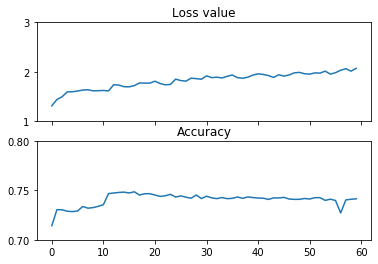

In [125]:
import pandas as pd

records = pd.read_csv(modelname +'.csv')
plt.figure()
plt.subplot(211)
plt.plot(records['val_loss'])
plt.yticks([1.0, 2.0, 3.0]) #plt.yticks([0.00,0.10,0.20,0.30])
plt.title('Loss value',fontsize=12)

ax = plt.gca()
ax.set_xticklabels([])



plt.subplot(212)
plt.plot(records['val_acc'])
plt.yticks([0.70, 0.75, 0.80]) #plt.yticks([0.93,0.95,0.97,0.99])
plt.title('Accuracy',fontsize=12)
plt.show()

# Score the trained models on the Test Data

In [126]:
clf = xgbc_clf #rfc_clf #xgbc_clf #voting_clf

In [127]:
clf.score(X_test_encoded, Y_test)

## Random Forest: max_depth = 5, random_state = 0 ##
# 0.69 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/ mean,std normalizing
# 0.71 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/o normalizing

## XGBoost: max_depth = 5, random_state = 0  ##
# 0.778 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/ mean,std normalizing
# 0.798 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/ mean,std normalizing, 
#   oversampling all to 70k, no removal of any variables
# 0.691 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/ mean,std normalizing, 
#   oversampling all to 70k, removing of "correlated" variables
# 0.778 accuracy for default threshold for mutliclass "normal", "dos", "probe", ..., encoding, log values, w/ mean,std normalizing, 
#   no resampling, no removal of any variables
# 0.866 accuracy for default threshold for mutliclass "normal", "dos", "probe", ONLY, encoding, log values, w/ mean,std normalizing, 
#   no resampling, no removal of any variables

# 0.678 accuracy for default threshold for mutliclass "normal", "dos", "probe", ONLY, encoding, log values, w/ mean,std normalizing, 
#   resampling u2r to 5000, removal of correlated variables above 0.8 => variables aren't linearly correlated?


0.77861071682044

In [128]:
predict = clf.predict(X_test_encoded)

In [129]:
predict[0:10]

array(['dos', 'dos', 'normal', 'probe', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal'], dtype=object)

In [130]:
confusion = confusion_matrix(Y_test, predict)
confusion

array([[6256, 1002,  200,    0,    0],
       [  67, 9440,  201,    2,    1],
       [ 166,  631, 1571,   53,    0],
       [   0, 2467,    4,  283,    0],
       [   0,  192,    3,    2,    3]], dtype=int64)

In [138]:
print(classification_report(Y_test, predict))

              precision    recall  f1-score   support

         dos       0.96      0.84      0.90      7458
      normal       0.69      0.97      0.81      9711
       probe       0.79      0.65      0.71      2421
         r2l       0.83      0.10      0.18      2754
         u2r       0.75      0.01      0.03       200

    accuracy                           0.78     22544
   macro avg       0.81      0.52      0.53     22544
weighted avg       0.81      0.78      0.74     22544

